In [1]:
import gurobipy as gp
from gurobipy import GRB

# Parameters
T = 24  # Time steps
P_max_pv = 500  # Max power of photovoltaic
P_max_L = 1000  # Max industrial demand
C = 3000  # Battery capacity
kappa = 36  # Demand charge
eta_c = 0.95  # Battery charging efficiency
eta_d = 0.92  # Battery discharging efficiency
SoC_final = 300  # Final state of charge

# Price and demand data (example)
lambda_t = [0.11, 0.11, 0.11, 0.11, 0.11, 0.12, 0.15, 0.17, 0.18, 0.16, 0.15, 0.13, 0.13, 0.13, 0.14, 0.13, 0.18, 0.14, 0.14, 0.14, 0.15, 0.15, 0.15, 0.12]
P_u_L = [0.68, 0.70, 0.68, 0.68, 0.68, 0.72, 0.85, 0.90, 0.97, 0.97, 0.98, 1.00, 0.99, 0.92, 0.90, 0.95, 0.94, 1.00, 0.96, 0.94, 0.82, 0.77, 0.76, 0.72]
P_u_pv = [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.15, 0.35, 0.55, 0.72, 0.85, 0.96, 1.00, 0.92, 0.87, 0.73, 0.55, 0.35, 0.15, 0.00, 0.00, 0.00, 0.00, 0.00]
psi_t = 0.05

# Model
m = gp.Model("Dispatch_Optimization")

# Decision variables
P_c = m.addVars(T, lb=0, name="P_c")  # Charging power
P_d = m.addVars(T, lb=0, name="P_d")  # Discharging power
P_b = m.addVars(T, lb=0, name="P_b")  # Power bought from grid
P_s = m.addVars(T, lb=0, name="P_s")  # Power sold to grid
SoC = m.addVars(T, lb=0, name="SoC")  # State of charge
w = m.addVars(T, vtype=GRB.BINARY, name="w")  # Charging indicator
u = m.addVars(T, vtype=GRB.BINARY, name="u")  # Power import/export indicator

# Auxiliary variable for the maximum power bought from the grid
P_b_max = m.addVar(lb=0, name="P_b_max")

# Constraints to set P_b_max as the maximum value of P_b
for t in range(T):
    m.addConstr(P_b_max >= P_b[t] + P_s[t])

# Objective function
m.setObjective(
    -kappa * P_b_max + 30 * gp.quicksum(lambda_t[t] * P_s[t] - (lambda_t[t] + psi_t) * P_b[t] for t in range(T)),
    GRB.MAXIMIZE
)

# Constraints
for t in range(T):
    m.addConstr(P_d[t] + P_b[t] + P_u_pv[t] * P_max_pv == P_c[t] + P_s[t] + P_u_L[t] * P_max_L)
    m.addConstr(P_c[t] <= 0.3 * C * w[t])
    m.addConstr(P_d[t] <= 0.2 * C * (1 - w[t]))
    m.addConstr(P_b[t] <= 5000 * u[t])
    m.addConstr(P_s[t] <= 5000 * (1 - u[t]))

# State of charge constraints
m.addConstr(SoC[0] == SoC_final + P_c[0]*eta_c - P_d[0]/eta_d)  # Initial state of charge
for t in range(1, T):
    m.addConstr(SoC[t] == SoC[t-1] + eta_c * P_c[t] - P_d[t] / eta_d)

# Battery limits
for t in range(T):
    m.addConstr(0.1 * C <= SoC[t])
    m.addConstr(SoC[t] <= 0.9 * C)

# Final state of charge
m.addConstr(SoC[T-1] == SoC_final)

# Optimize
m.optimize()



Set parameter Username
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[x86] - Darwin 21.6.0 21H1320)

CPU model: Intel(R) Core(TM) i7-6700HQ CPU @ 2.60GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 217 rows, 169 columns and 504 nonzeros
Model fingerprint: 0x3aaf673c
Variable types: 121 continuous, 48 integer (48 binary)
Coefficient statistics:
  Matrix range     [9e-01, 5e+03]
  Objective range  [3e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+02, 5e+03]
Found heuristic solution: objective -129947.4474
Presolve removed 109 rows and 61 columns
Presolve time: 0.02s
Presolved: 108 rows, 108 columns, 303 nonzeros
Variable types: 80 continuous, 28 integer (28 binary)

Root relaxation: objective -1.183939e+05, 69 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*

In [19]:
# Verificar si la optimización fue exitosa
if m.status == GRB.OPTIMAL:
    # Crear diccionarios para almacenar los resultados de las variables
    P_c_sol = {t: P_c[t].x for t in range(T)}  # Potencia de carga
    P_d_sol = {t: P_d[t].x for t in range(T)}  # Potencia de descarga
    P_b_sol = {t: P_b[t].x for t in range(T)}  # Potencia comprada a la red
    P_s_sol = {t: P_s[t].x for t in range(T)}  # Potencia vendida a la red
    SoC_sol = {t: SoC[t].x for t in range(T)}  # Estado de carga de la batería
    
    # Imprimir los resultados
    print("Resultados de la optimización:")
    
    print("\nPotencia de carga (P_c):")
    for t in range(T):
        print(f"Hora {t+1}: {P_c_sol[t]} kW")
    
    print("\nPotencia de descarga (P_d):")
    for t in range(T):
        print(f"Hora {t+1}: {P_d_sol[t]} kW")
    
    print("\nPotencia comprada a la red (P_b):")
    for t in range(T):
        print(f"Hora {t+1}: {P_b_sol[t]} kW")
    
    print("\nPotencia vendida a la red (P_s):")
    for t in range(T):
        print(f"Hora {t+1}: {P_s_sol[t]} kW")
    
    print("\nEstado de carga de la batería (SoC):")
    for t in range(T):
        print(f"Hora {t+1}: {SoC_sol[t]} kWh")
else:
    print("No se encontró una solución óptima.")


Resultados de la optimización:

Potencia de carga (P_c):
Hora 1: 26.79511533242885 kW
Hora 2: 6.79511533242885 kW
Hora 3: 26.79511533242885 kW
Hora 4: 26.79511533242885 kW
Hora 5: 26.79511533242885 kW
Hora 6: 0.0 kW
Hora 7: 0.0 kW
Hora 8: 0.0 kW
Hora 9: 0.0 kW
Hora 10: 0.0 kW
Hora 11: 151.79511533242885 kW
Hora 12: 186.79511533242885 kW
Hora 13: 216.79511533242885 kW
Hora 14: 246.79511533242885 kW
Hora 15: 241.79511533242885 kW
Hora 16: 121.79511533242885 kW
Hora 17: 0.0 kW
Hora 18: 0.0 kW
Hora 19: 0.0 kW
Hora 20: 0.0 kW
Hora 21: 0.0 kW
Hora 22: 0.0 kW
Hora 23: 0.0 kW
Hora 24: 0.0 kW

Potencia de descarga (P_d):
Hora 1: 0.0 kW
Hora 2: 0.0 kW
Hora 3: 0.0 kW
Hora 4: 0.0 kW
Hora 5: 0.0 kW
Hora 6: 13.20488466757115 kW
Hora 7: 68.20488466757115 kW
Hora 8: 18.20488466757115 kW
Hora 9: 0.0 kW
Hora 10: 0.0 kW
Hora 11: 0.0 kW
Hora 12: 0.0 kW
Hora 13: 0.0 kW
Hora 14: 0.0 kW
Hora 15: 0.0 kW
Hora 16: 0.0 kW
Hora 17: 246.44939213025893 kW
Hora 18: 118.20488466757115 kW
Hora 19: 178.20488466757115 k

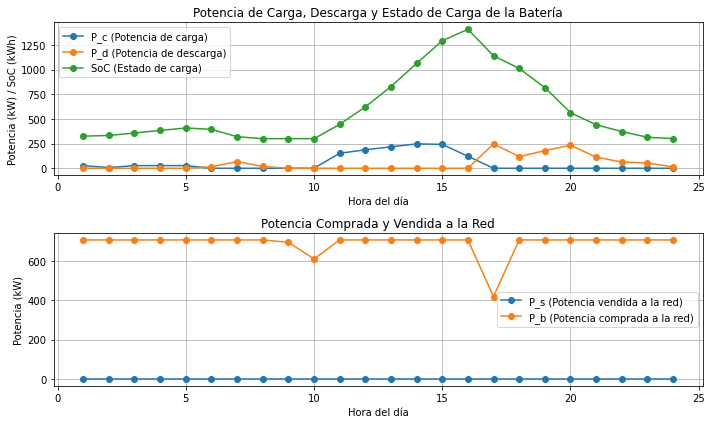

In [20]:
import matplotlib.pyplot as plt

# Plot P_c_sol, P_d_sol, and SoC_sol
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(range(1, T+1), [P_c_sol[t] for t in range(T)], label='P_c (Potencia de carga)', marker='o')
plt.plot(range(1, T+1), [P_d_sol[t] for t in range(T)], label='P_d (Potencia de descarga)', marker='o')
plt.plot(range(1, T+1), [SoC_sol[t] for t in range(T)], label='SoC (Estado de carga)', marker='o')

plt.title('Potencia de Carga, Descarga y Estado de Carga de la Batería')
plt.xlabel('Hora del día')
plt.ylabel('Potencia (kW) / SoC (kWh)')
plt.legend()
plt.grid(True)

# Plot P_s_sol and P_b_sol
plt.subplot(2, 1, 2)
plt.plot(range(1, T+1), [P_s_sol[t] for t in range(T)], label='P_s (Potencia vendida a la red)', marker='o')
plt.plot(range(1, T+1), [P_b_sol[t] for t in range(T)], label='P_b (Potencia comprada a la red)', marker='o')

plt.title('Potencia Comprada y Vendida a la Red')
plt.xlabel('Hora del día')
plt.ylabel('Potencia (kW)')
plt.legend()
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()
